In [2]:
import cv2
import mediapipe as mp
import pandas as pd

# Initialize Mediapipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=2)

# Open the video file
cap = cv2.VideoCapture(r'C:\Users\Gusul\Desktop\version2.mp4')
head_coordinates_3d = []
i = 1

# Process the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert BGR frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(frame_rgb)

    if results.pose_landmarks:
        # Get the 3D coordinates of the nose (index 0 corresponds to the nose)
        nose = results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE]
        x = int(nose.x * frame.shape[1])
        y = int(nose.y * frame.shape[0])
        z = 900 * nose.z  # Z coordinate represents the depth relative to the camera
        if i % 5 == 0:
            head_coordinates_3d.append((x, y, z))
        i = i + 1

cap.release()

# Save the 3D coordinates of the head to a DataFrame
df = pd.DataFrame(head_coordinates_3d, columns=['X', 'Y', 'Z'])

# Save to an Excel file
excel_file_path = r'C:\Users\Gusul\Desktop\head_coordinates_3d_2.xlsx'
df.to_excel(excel_file_path, index=False)

print(f"Total frames processed: {len(head_coordinates_3d)}")
print(f"Data saved to {excel_file_path}")

Total frames processed: 281
Data saved to C:\Users\Gusul\Desktop\head_coordinates_3d_2.xlsx


In [4]:
import pandas as pd

# Load the Excel file
file_path = r'C:\Users\Gusul\Desktop\head_coordinates_3d_2.xlsx'  
data = pd.read_excel(file_path)

# Define a function to remove outliers for each column using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers for columns X, Y, and Z
data_cleaned = data.copy()
for column in ['X', 'Y', 'Z']:
    data_cleaned = remove_outliers_iqr(data_cleaned, column)

# Save the cleaned data to a new Excel file
data_cleaned.to_excel(r'C:\Users\Gusul\Desktop\cleaned_head_coordinates_3d_2.xlsx', index=False)


In [5]:
import pandas as pd

# Load the Excel file
df = pd.read_excel(r'C:\Users\Gusul\Desktop\cleaned_head_coordinates_3d_2.xlsx')

# Extract every 15th row (starting from the first row)
extracted_data = df.iloc[::15]

# Save the extracted data to a new Excel file
extracted_data.to_excel(r'C:\Users\Gusul\Desktop\keypoints_2.xlsx', index=False)

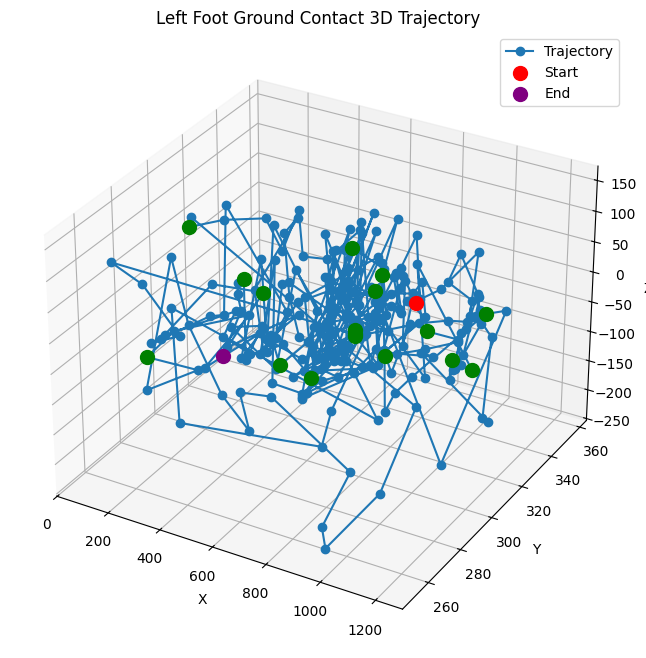

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load the uploaded Excel file
file_path = r'C:\Users\Gusul\Desktop\cleaned_head_coordinates_3d_2.xlsx'
data = pd.read_excel(file_path)

# Extract X, Y, Z data
x_points = data['X']
y_points = data['Y']
z_points = data['Z']

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x_points, y_points, z_points, marker='o', label='Trajectory')
ax.scatter(x_points.iloc[0], y_points.iloc[0], z_points.iloc[0], color='red', s=100, label='Start')
ax.scatter(x_points.iloc[-1], y_points.iloc[-1], z_points.iloc[-1], color='purple', s=100, label='End')
# Highlight the start (first point) and end (last point)
for i in range(data.shape[0]):
    if i%15 == 0 and i != 0:
        ax.scatter(x_points.iloc[i], y_points.iloc[i], z_points.iloc[i], color='green', s=100)

# Set labels
ax.set_title('Head 3D Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show legend
ax.legend()

# Display the plot
plt.show()